# <center> Guia 4 - Anteproyecto </center>
# <center> Auditoria Datos Contugas - Análisis exploratorio de datos </center>

<center> Grupo 14: Diana Bayona, Juan Diego Perez, Jorge Rodriguez y Santiago Gutiérrez </center>

Se presenta el análisis descriptivo y/o exploratorio de los datos, los cuales fueron brindados por contugas y corresponden a la información de consumo de gas de 20 clientes.

## Librerias

In [1]:
import numpy as np
import pandas as pd 
import openpyxl

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning)

## Cargue de la Información

In [2]:
# Ruta del archivo Excel
file_path = 'Datos_Contugas.xlsx'# Asegúrate de que la ruta al archivo sea correcta

# Cargar el archivo Excel y obtener los nombres de las hojas
excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names

# Lista para almacenar los DataFrames
all_data = []

# Cargar y unificar las hojas
for idx, sheet in enumerate(sheet_names, start=1):
    df = pd.read_excel(file_path, sheet_name=sheet)
    df['Client_ID'] = f'Client_{idx}'  # Crear un ID único por cliente
    all_data.append(df)

# Combinar todos los DataFrames en uno solo
datos = pd.concat(all_data, ignore_index=True)

Se cargan y consolidan los datos desde el archivo Excel que contiene múltiples hojas. Cada hoja representa los datos del consumo de gas de un cliente diferente, y se recorre utilizando un bucle para leerlos y unificarlos en un único DataFrame. A cada cliente se le asigna un identificador único (Client_ID).

In [3]:
print("La dimensión de los datos es: " + str(datos.shape))
datos.head(5)

La dimensión de los datos es: (847960, 5)


,Fecha,Presion,Temperatura,Volumen,Client_ID
0,2019-01-14 00:00:00,17.732563,28.209354,20.969751,Client_1
1,2019-01-14 01:00:00,17.747776,28.518614,17.845739,Client_1
2,2019-01-14 02:00:00,17.758916,28.230191,20.975914,Client_1
3,2019-01-14 03:00:00,17.727940,27.811509,20.592299,Client_1
4,2019-01-14 04:00:00,17.746484,27.795293,21.690626,Client_1


La base de datos final cuenta con un total de 847,960 registros y 5 columnas: Fecha, Presión, Temperatura, Volumen y Client_ID. Este conjunto de datos consolidado nos permite realizar los diferentes análisis globales o individuales por cliente, facilitando la identificación de patrones de consumo y la evaluación del sistema de distribución de gas.

## Descripción Variables

* **Fecha:** La columna Fecha representa la marca temporal asociada a cada medición de consumo de gas. Está registrada en formato YYYY-MM-DD HH:MM:SS, lo que permite un análisis detallado de los patrones temporales. Esta variable es fundamental para identificar tendencias a lo largo del tiempo, analizar periodos específicos de alto o bajo consumo, y asegurar la correcta secuencialidad de los datos. Un ejemplo típico podría ser 2019-01-14 00:00:00.

* **Presión:** La Presión mide la fuerza ejercida por el gas en el sistema y es una variable numérica continua. Esta expresada en unidades bar. El rango de valores dependen del tipo de sistema. Entre los sistemas de transmisión de alta presión se esperan valores en un rango entre 30 a 80 bar, sistemas de media presión de 4 a 5 bar y en sistemas de baja presión 0.01 a 1 bar. Este indicador es crucial para garantizar la seguridad y eficiencia en la distribución del gas. Un registro típico podría mostrar una presión de 17 bar.

* **Temperatura:** La Temperatura refleja el entorno o las condiciones del sistema en el momento de la medición. Es una variable numérica continua que se registra en grados Celsius (°C). Esta variable es clave porque el comportamiento del gas puede variar significativamente con los cambios de temperatura. Un valor típico podría ser 28.21 °C, lo que indica una temperatura ambiental en condiciones normales. Pero puede variar en función del sistema y las condiciones ambientales.

* **Volumen:** El Volumen representa la cantidad de gas consumida o medida en un período determinado. Esta variable numérica continua se expresa en metros cúbicos (m³). Es un indicador directo del consumo y es esencial para la facturación y la optimización del sistema. Por ejemplo, un registro podría indicar un volumen de 20.97 m³, mostrando la cantidad de gas utilizada en un intervalo específico.

* **Client_ID:** El Client_ID es un identificador único que distingue a cada cliente en el sistema. Es una variable categórica, formada por etiquetas como Client_1, Client_2, y así sucesivamente, hasta Client_20. Este identificador facilita el análisis individual y comparativo de los clientes, permitiendo evaluar patrones específicos de consumo y comportamiento en el sistema.

## Análisis Preliminar

In [4]:
def validate_integrity(datos):
    # Verificar valores nulos
    null_values = datos.isnull().sum()
    print("Valores nulos por columna:")
    print(null_values)
    
    # Verificar duplicados
    duplicates = datos.duplicated().sum()
    print(f"\nNúmero de filas duplicadas: {duplicates}")

In [5]:
def validate_completeness(datos):
    # Verificar registros sin Client_ID
    missing_clients = datos['Client_ID'].isnull().sum()
    print(f"Número de registros sin Client_ID: {missing_clients}")
    
    # Verificar fechas faltantes o no secuenciales para cada cliente
    fechas_completas = datos.groupby('Client_ID')['Fecha'].apply(lambda x: x.is_monotonic_increasing)
    print("\nClientes con fechas no secuenciales o faltantes:")
    print(fechas_completas[~fechas_completas])

In [6]:
def validate_coherence(datos):
    # Valores esperados para variables específicas
    inconsistent_temps = datos[(datos['Temperatura'] < -50) | (datos['Temperatura'] > 60)]
    inconsistent_pressure = datos[(datos['Presion'] < 0) | (datos['Presion'] > 200)]
    inconsistent_volume = datos[datos['Volumen'] < 0]
    
    print(f"Registros con Temperatura inconsistente: {len(inconsistent_temps)}")
    print(f"Registros con Presión inconsistente: {len(inconsistent_pressure)}")
    print(f"Registros con Volumen inconsistente: {len(inconsistent_volume)}")

In [7]:
def validate_consistency(datos):
    # Comprobar consistencia de relaciones, ejemplo: Volumen vs Presion
    correlation = datos[['Volumen', 'Presion']].corr().iloc[0, 1]
    print(f"Correlación entre Volumen y Presión: {correlation:.2f}")
    
    # Verificar si existen valores fuera de los intervalos esperados simultáneamente
    unexpected_relations = datos[(datos['Presion'] > 100) & (datos['Volumen'] < 10)]
    print(f"Número de relaciones inconsistente Volumen vs Presión: {len(unexpected_relations)}")

In [8]:
def validate_format(datos):
    # Verificar formato de la columna de fecha
    try:
        datos['Fecha'] = pd.to_datetime(datos['Fecha'])
        print("Formato de fechas es válido.")
    except Exception as e:
        print(f"Formato de fechas inválido: {e}")
    
    # Verificar tipos de datos
    print("\nTipos de datos por columna:")
    print(datos.dtypes)

In [9]:
def validate_timeliness(datos):
    max_date = datos['Fecha'].max()
    print(f"Última fecha registrada: {max_date}")
    
    if max_date < pd.Timestamp.now() - pd.Timedelta(days=7):
        print("Advertencia: Los datos no están actualizados.")

In [10]:
def validate_data(datos):
    print("Validación de Integridad:")
    validate_integrity(datos)
    
    print("\nValidación de Completitud:")
    validate_completeness(datos)
    
    print("\nValidación de Coherencia:")
    validate_coherence(datos)
    
    print("\nValidación de Consistencia:")
    validate_consistency(datos)
    
    print("\nValidación de Temporalidad:")
    validate_timeliness(datos)
    
    print("\nValidación de Formato:")
    validate_format(datos)

In [11]:
validate_data(datos)

Validación de Integridad:
Valores nulos por columna:
Fecha          0
Presion        0
Temperatura    0
Volumen        0
Client_ID      0
dtype: int64

Número de filas duplicadas: 0

Validación de Completitud:
Número de registros sin Client_ID: 0

Clientes con fechas no secuenciales o faltantes:
Client_ID
Client_16    False
Client_8     False
Name: Fecha, dtype: bool

Validación de Coherencia:
Registros con Temperatura inconsistente: 0
Registros con Presión inconsistente: 0
Registros con Volumen inconsistente: 0

Validación de Consistencia:
Correlación entre Volumen y Presión: -0.30
Número de relaciones inconsistente Volumen vs Presión: 0

Validación de Temporalidad:
Última fecha registrada: 2023-12-31 23:00:00
Advertencia: Los datos no están actualizados.

Validación de Formato:
Formato de fechas es válido.

Tipos de datos por columna:
Fecha          datetime64[ns]
Presion               float64
Temperatura           float64
Volumen               float64
Client_ID              object
d

La auditoría de los datos muestra un conjunto limpio y bien estructurado en la mayoría de las dimensiones evaluadas. No se encontraron valores nulos, duplicados ni registros sin identificadores de cliente, lo que asegura la **integridad** de los datos. La **completitud** también es adecuada, aunque se identificaron dos clientes (Client_16 y Client_8) con posibles problemas de secuencialidad en sus fechas, lo que requiere una revisión adicional. En términos de **coherencia**, las variables de temperatura, presión y volumen están dentro de rangos esperados, sin registros inconsistentes. La **consistencia** muestra una correlación negativa moderada entre volumen y presión (-0.30), lo que es coherente con las leyes de los gases, y no se encontraron relaciones incoherentes entre estas variables. En la validación de **temporalidad**, se detecta que la última fecha registrada es del 31 de diciembre de 2023, indicando que los datos no están actualizados, lo cual podría impactar futuros análisis. Finalmente, el **formato** es correcto, con tipos de datos bien definidos, incluyendo un formato válido para la columna de Fecha. En general, los datos son fiables, pero es necesario resolver la desactualización temporal si asi se requiere y revisar los clientes con posibles brechas de fechas.

In [12]:
def check_date_sequence(datos, client_id):
    client_data = datos[datos['Client_ID'] == client_id].sort_values('Fecha')
    client_data['Diferencia'] = client_data['Fecha'].diff().dt.total_seconds() / 3600  # Diferencia en horas
    print(f"Secuencia de fechas para {client_id}:\n")
    print(client_data[['Fecha', 'Diferencia']])
    print("\nRegistros con diferencias significativas:\n")
    print(client_data[client_data['Diferencia'] > 1])  # Ajusta este valor según lo esperado

In [13]:
check_date_sequence(datos, 'Client_16')
check_date_sequence(datos, 'Client_8')

Secuencia de fechas para Client_16:

                     Fecha  Diferencia
634906 2019-01-14 00:00:00         NaN
634907 2019-01-14 01:00:00         1.0
634908 2019-01-14 02:00:00         1.0
634909 2019-01-14 03:00:00         1.0
634910 2019-01-14 04:00:00         1.0
...                    ...         ...
678048 2023-12-31 19:00:00         1.0
678049 2023-12-31 20:00:00         1.0
678050 2023-12-31 21:00:00         1.0
678051 2023-12-31 22:00:00         1.0
678052 2023-12-31 23:00:00         1.0

[43147 rows x 2 columns]

Registros con diferencias significativas:

                     Fecha    Presion  Temperatura     Volumen  Client_ID  \
635034 2019-01-19 09:00:00  16.102134    30.264175  268.962348  Client_16   
635222 2019-01-27 06:00:00  17.110056    27.139662  124.895966  Client_16   
636299 2019-03-13 13:00:00  17.260443    28.853453   76.345927  Client_16   
636311 2019-03-14 02:00:00  16.313019    30.775164  221.512574  Client_16   
636321 2019-03-14 13:00:00  16.344874   

Los resultados muestran que tanto Client_16 como Client_8 tienen registros con diferencias significativas en la secuencia temporal. Aunque la mayoría de los registros tienen un intervalo de 1 hora entre mediciones, se identificaron 138 casos en cada cliente donde las diferencias son superiores a una hora, con valores comunes de 2 horas y algunos intervalos más largos, como 11 horas. Estas discrepancias pueden indicar pérdida de datos o fallas en la captura continua, lo cual podría afectar la precisión del análisis temporal. El patrón sugiere que los problemas son esporádicos y no recurrentes en periodos específicos.

In [14]:
def find_missing_dates(datos, client_id, freq='h'):
    client_data = datos[datos['Client_ID'] == client_id].sort_values('Fecha')
    expected_dates = pd.date_range(start=client_data['Fecha'].min(), 
                                   end=client_data['Fecha'].max(), freq=freq)
    actual_dates = client_data['Fecha']
    missing_dates = expected_dates.difference(actual_dates)
    print(f"Fechas faltantes para {client_id}:")
    print(missing_dates)

In [15]:
find_missing_dates(datos, 'Client_16')
find_missing_dates(datos, 'Client_8')

Fechas faltantes para Client_16:
DatetimeIndex(['2019-01-19 08:00:00', '2019-01-27 05:00:00',
               '2019-03-13 03:00:00', '2019-03-13 04:00:00',
               '2019-03-13 05:00:00', '2019-03-13 06:00:00',
               '2019-03-13 07:00:00', '2019-03-13 08:00:00',
               '2019-03-13 09:00:00', '2019-03-13 10:00:00',
               ...
               '2023-10-23 16:00:00', '2023-10-23 17:00:00',
               '2023-10-23 18:00:00', '2023-10-23 19:00:00',
               '2023-10-23 20:00:00', '2023-10-23 21:00:00',
               '2023-10-23 22:00:00', '2023-11-04 07:00:00',
               '2023-11-09 06:00:00', '2023-11-10 03:00:00'],
              dtype='datetime64[ns]', length=366, freq=None)
Fechas faltantes para Client_8:
DatetimeIndex(['2019-01-19 08:00:00', '2019-01-27 05:00:00',
               '2019-03-13 03:00:00', '2019-03-13 04:00:00',
               '2019-03-13 05:00:00', '2019-03-13 06:00:00',
               '2019-03-13 07:00:00', '2019-03-13 08:00:00',


Los resultados muestran que ambos clientes presentan 366 fechas faltantes, distribuidas a lo largo de varios períodos. Estas fechas faltantes representan mediciones no registradas en intervalos esperados de 1 hora, lo que confirma las brechas temporales detectadas previamente. Las fechas perdidas se concentran en varios lapsos específicos, como el 19 de enero de 2019, el 13 de marzo de 2019, y los días 23 de octubre y 9 de noviembre de 2023, entre otros.

Estas ausencias pueden deberse a fallos en la recolección de datos, interrupciones en los dispositivos de monitoreo o pérdida de registros en la base de datos. Es fundamental investigar las causas para evitar que estos problemas persistan en futuras mediciones. Además, se podría considerar métodos de imputación de datos (como interpolación lineal o regresión) para completar los valores faltantes y mantener la continuidad del análisis temporal.

## Análisis Descriptivo

In [16]:
datos.describe()

,Fecha,Presion,Temperatura,Volumen
count,847960,847960.000000,847960.000000,847960.000000
mean,2021-07-08 22:08:19.659418112,16.072957,25.198239,62.328206
min,2019-01-14 00:00:00,2.934873,-5.257899,0.000000
25%,2020-04-13 23:00:00,17.097350,22.693027,0.000000
50%,2021-07-07 06:00:00,17.570449,25.379859,21.773567
75%,2022-10-06 02:15:00,17.694254,27.886244,99.319649
max,2023-12-31 23:00:00,20.307852,50.019853,577.413425
std,NaN,4.186408,3.790497,80.498112


Se cuenta con 847,960 observaciones para cada una de las variables, lo que confirma la ausencia de datos faltantes. Además, las mediciones abarcan desde el 14 de enero de 2019 hasta el 31 de diciembre de 2023, cubriendo casi cinco años de registros.

**Presión:**
La presión del suministro de gas presenta un promedio de 16.07 bar y una desviación estándar de 4.19, lo que refleja una variabilidad moderada en las mediciones. Los valores oscilan entre un mínimo de 2.93 bar y un máximo de 20.31 bar, indicando la presencia de condiciones extremas en ciertos momentos. Sin embargo, la mediana de 17.57 bar y los percentiles cercanos a este valor muestran que, en general, las mediciones de presión se mantienen relativamente estables.

**Temperatura:**
Por otro lado, la temperatura tiene un promedio de 25.19 °C, con una desviación estándar de 3.79 °C, lo que indica que las mediciones están distribuidas de manera relativamente uniforme alrededor de la media. Los valores fluctúan entre un mínimo de -5.26 °C y un máximo de 50.02 °C, evidenciando la capacidad del sistema para operar bajo condiciones climáticas tanto frías como muy cálidas. La mediana, que se sitúa en 25.38 °C, respalda la idea de que la mayoría de las observaciones se concentran cerca del promedio, sugiriendo una estabilidad en la distribución de la temperatura con pocas desviaciones extremas.

**Volumen:**
Finalmente, el volumen de suministro de gas para los diferentes clientes es en promedio de 62.33 m^3, lo cual representa un valor considerable en las mediciones de consumo de gas. Sin embargo, la desviación estándar de 80.50 m³ sugiere una notable dispersión en los datos, indicando grandes diferencias en los volúmenes registrados, probablemente asociados con variaciones en la demanda o almacenamiento de gas. Los valores oscilan entre 0.00 m³ y un máximo de 577.41 m³, lo que refleja una alta variabilidad en el suministro. Cabe destacar que, en al menos el 25% de las observaciones, los volúmenes son 0, posiblemente señalando periodos de inactividad o clientes sin consumo registrado. Por otro lado, el percentil 75% alcanza un volumen de 99.32 m³, lo que sugiere que la mayoría de las mediciones se encuentran por debajo de este valor, aunque también existen casos aislados con volúmenes mucho mayores.


In [17]:
def descriptive_stats_per_client(datos):
    clients = datos['Client_ID'].unique()  # Obtener IDs únicos de los clientes
    
    descriptive_summary = {}  # Diccionario para almacenar los resultados

    for client in clients:
        client_data = datos[datos['Client_ID'] == client]  # Filtrar datos por cliente
        descriptive_summary[client] = client_data[['Temperatura', 'Presion', 'Volumen']].describe()  # Resumen estadístico
        
        print(f"Descriptive statistics for {client}:\n")
        print(descriptive_summary[client])
        print("\n" + "-"*50 + "\n")
    
    return descriptive_summary

# Llama a la función con tu DataFrame
stats_per_client = descriptive_stats_per_client(datos)  # Cambia por el DataFrame que contenga tus datos

Descriptive statistics for Client_1:

        Temperatura       Presion       Volumen
count  43412.000000  43412.000000  43412.000000
mean      25.575853     17.535934     19.976401
std        2.756246      0.358310      7.939171
min       15.401803     15.742337      0.000000
25%       23.587235     17.590781     16.248989
50%       25.711326     17.651439     22.470213
75%       27.695776     17.711107     25.533223
max       32.869112     18.074274     65.936644

--------------------------------------------------

Descriptive statistics for Client_2:

        Temperatura       Presion       Volumen
count  41382.000000  41382.000000  41382.000000
mean      27.673040     17.526440     61.819045
std        2.345356      0.318984     17.495571
min       17.884059     16.129015      0.000000
25%       25.859054     17.581711     51.809989
50%       27.493743     17.637486     61.814487
75%       29.825196     17.675036     71.742183
max       35.208346     18.106402    517.564868

------

* **Client_1:** Este cliente muestra condiciones operativas estables con una temperatura promedio de 25.58°C, variando entre 15.40°C y 32.87°C. La presión se mantiene en un rango estrecho, con una media de 17.54 bar y un máximo de 18.07 bar, lo que indica un sistema de presión altamente controlado. El volumen de consumo presenta más variabilidad, con un promedio de 19.98 m³ y valores que oscilan desde 0 m³ hasta 65.94 m³, reflejando momentos de mayor demanda.


* **Client_2:** Este cliente opera con una temperatura media de 27.67°C, mostrando un rango de variación entre 17.88°C y 35.21°C, lo que indica fluctuaciones dentro de un entorno cálido. La presión promedio es de 17.53 bar, con valores que oscilan entre 16.13 bar y 18.11 bar, reflejando estabilidad en el sistema. El volumen de consumo tiene una media de 61.82 m³, alcanzando un máximo de 517.56 m³, lo que sugiere picos significativos en ciertos periodos.

* **Client_3:** Con una temperatura promedio de 26.35°C, este cliente opera dentro de un rango moderado, de 14.93°C a 34.01°C. La presión es notablemente baja, con una media de 3.57 bar y un máximo de 4.04 bar, lo que sugiere un sistema distinto al de otros clientes. El volumen de consumo es alto, con un promedio de 117.50 m³, llegando a un máximo de 356.72 m³, indicando una demanda sostenida.

* **Client_4:** Este cliente opera con una temperatura media de 23.24°C, dentro de un rango de 12.71°C a 36.90°C, lo que refleja una mayor variabilidad térmica. La presión promedio es de 17.64 bar, oscilando entre 15.21 bar y 20.11 bar, lo que sugiere un sistema operando dentro de límites seguros. El volumen de consumo es bajo, con una media de 17.35 m³, pero alcanza un máximo de 363.00 m³, indicando consumos esporádicamente altos.

* **Client_5:** Este cliente muestra una temperatura promedio de 23.67°C, con un rango que varía de 10.50°C a 41.76°C, lo que evidencia una mayor amplitud térmica. La presión promedio es de 17.49 bar, con un rango entre 14.49 bar y 19.01 bar, reflejando cierta variabilidad. El volumen de consumo es bajo, con una media de 7.82 m³ y un máximo de 89.25 m³, lo que sugiere un consumo moderado y controlado.

* **Client_6:** Este cliente opera en un entorno de temperatura moderada, con una media de 26.39°C y un rango que varía de 14.16°C a 34.19°C, mostrando cierta amplitud térmica. La presión promedio se mantiene estable en 17.57 bar, con valores que van desde 13.81 bar hasta 19.72 bar, lo que indica un sistema mayormente controlado. El volumen de consumo es alto, con un promedio de 153.80 m³ y un máximo de 366.66 m³, reflejando periodos de demanda significativa.

* **Client_7:** Este cliente presenta una temperatura promedio de 23.62°C, con un rango de variación amplio desde 0.43°C hasta 39.98°C, lo que evidencia posibles fluctuaciones extremas. La presión promedio es de 17.49 bar, moviéndose entre 14.42 bar y 20.31 bar, lo cual refleja cierta estabilidad con picos esporádicos. El volumen de consumo es bajo, con un promedio de 27.29 m³ y un máximo de 175.76 m³, sugiriendo consumos ocasionales más elevados.

* **Client_8:** Con una temperatura media de 26.81°C, este cliente se sitúa en un rango de 14.84°C a 37.37°C, mostrando una considerable variabilidad térmica. La presión promedio es de 16.71 bar, fluctuando entre 14.99 bar y 18.95 bar, indicando un sistema de presión moderadamente controlado. El volumen de consumo es alto, con una media de 178.59 m³ y un máximo de 522.78 m³, destacando picos importantes en ciertos periodos.

* **Client_9:** Este cliente mantiene una temperatura media más baja de 22.07°C, oscilando entre 11.82°C y 31.78°C. La presión promedio es de 17.47 bar, variando dentro de un margen más estrecho de 16.49 bar a 18.43 bar, reflejando un sistema estable. El volumen de consumo es bajo, con una media de 12.73 m³, pero con un máximo de 366.02 m³, sugiriendo momentos de demanda poco frecuentes pero altos.

* **Client_10:** Este cliente opera con una temperatura media de 23.50°C, en un rango de 14.29°C a 35.07°C, mostrando un entorno térmico moderado. La presión promedio es de 17.47 bar, con valores que van de 16.47 bar a 18.57 bar, lo cual indica estabilidad operativa. El volumen de consumo es bajo, con un promedio de 11.79 m³ y un máximo de 247.07 m³, lo que sugiere un consumo generalmente controlado con algunos picos ocasionales.

* **Client_11:** Este cliente tiene 42.248 observaciones y presenta una temperatura media de 26.31 °C, con un rango que varía entre 13.73 °C y 34.36 °C, lo que indica fluctuaciones dentro de un entorno moderado a cálido. La presión promedio es de 3.55 bar, con valores que oscilan entre 2.93 bar y 3.95 bar, reflejando una alta estabilidad en el sistema. El volumen de consumo tiene una media de 131.65 m³, con un máximo de 298.26 m³, lo que sugiere variaciones notables en ciertos periodos. La mayoría de las mediciones de volumen se concentran alrededor de 136.08 m³, según los percentiles.

* **Client_12:** El cliente 12 opera con una temperatura media de 26.69 °C, mostrando un rango de variación que va desde -5.26 °C hasta 50.02 °C, lo que refleja la capacidad de enfrentar tanto condiciones muy frías como extremadamente cálidas. La presión promedio es de 17.83 bar, con valores que oscilan entre 13.74 bar y 20.23 bar, indicando cierta estabilidad en el sistema pese a la presencia de extremos. El volumen de consumo tiene una media de 33.73 m³, alcanzando un máximo de 284.48 m³, lo que sugiere picos considerables en ciertos momentos. Los 41.776 datos muestran que la mayoría de las mediciones de volumen están por debajo de 77.65 m³, con un 50% de las observaciones en 0 m³, lo cual podría apuntar a períodos de baja o nula actividad.

* **Client_13:** Este cliente registra 41.059 observaciones, las cuales indican que opera con una temperatura media de 21.59 °C, con un rango de variación de 12.24 °C a 29.75 °C, mientras que la presión promedio se encuentra en 17.49 bar, con fluctuaciones que van de 16.51 bar a 18.47 bar, lo que evidencia la estabilidad tanto en temperatura como en presión. El volumen de consumo tiene una media baja de 10.28 m³, pero con una notable dispersión, ya que los valores varían entre 0.00 m³ y un máximo de 253.87 m³, lo que evidencia la presencia de periodos con picos de consumo y otros con nula o baja actividad, ya que el percentil 75% se sitúa aún en 0 m³.

* **Client_14:** Este cliente tiene 43.415 registros y presenta una temperatura promedio de 26.66 °C, con un rango que va desde 5.68 °C hasta 45.38 °C, lo que refleja una exposición a condiciones tanto frescas como cálidas. La presión promedio es de 17.52 bar, con valores que oscilan entre 13.62 bar y 20.03 bar, indicando una estabilidad. En cuanto al volumen, la media es de 7.30 m³, con un rango entre 0.00 m³ y 36.79 m³, con la mayoría de las mediciones situadas entre 3.10 m³ y 10.87 m³, lo que sugiere que los consumos suelen estar concentrados en valores relativamente bajos. 

* **Client_15:** Este cliente tiene una temperatura media de 24.03 °C, con un rango que varía entre 14.71 °C y 35.66 °C, indicando un entorno mayormente templado. La presión promedio es de 17.50 bar, con valores que se mantienen entre 16.51 bar y 18.49 bar, lo que refleja una alta estabilidad. En cuanto al volumen de consumo, la media es de 12.55 m³ y oscila entre 0.00 m³ y 398.04 m³, y aunque el 75% de las mediciones están por debajo de 0 m³, también se registran algunos picos significativos en los valores más altos.

* **Client_16:** Este cliente presenta una temperatura promedio de 27.48°C, con valores que oscilan entre 19.15°C y 32.66°C. La presión promedio es de 16.71 bar, con un rango de 14.73 bar a 19.44 bar, indicando un sistema de presión controlado con una ligera variabilidad. En cuanto al volumen de consumo, el promedio es de 178.13 m³, con un máximo de 409.87 m³, lo que sugiere una demanda considerablemente variable, con picos ocasionales de alto consumo, aunque la mayor parte de los registros se encuentran por debajo de los valores máximos.

* **Client_17:** Este cliente tiene una temperatura promedio de 25.85°C, con un rango de 18.45°C a 31.92°C, lo que indica una operación en un entorno cálido y moderadamente variable. La presión promedio es de 17.53 bar, con fluctuaciones entre 15.27 bar y 18.45 bar, lo que denota un sistema con un control bastante estable. El volumen de consumo es bajo en promedio, con una media de 20.56 m³ y un máximo de 48.50 m³, lo que indica que los picos de consumo son moderados, con una mayoría de los registros concentrados en valores más bajos.

* **Client_18:** La temperatura promedio de este cliente es de 27.67°C, con un rango que varía entre 16.38°C y 33.79°C, mostrando una ligera fluctuación térmica en un entorno cálido. La presión promedio es de 17.55 bar, variando entre 16.22 bar y 17.82 bar, lo que sugiere un sistema de presión muy controlado y estable. En cuanto al volumen de consumo, la media es de 61.76 m³, con un máximo de 577.41 m³, indicando una demanda moderada con algunos picos significativos, sugiriendo un consumo con momentos de alta variabilidad, pero dentro de rangos controlables.

* **Client_19:** Este cliente tiene una temperatura promedio de 23.22°C, con un rango que va de 16.18°C a 30.64°C, reflejando un entorno moderadamente frío a templado. La presión promedio es de 17.67 bar, con variaciones que van de 16.25 bar a 18.26 bar, lo que indica estabilidad en el sistema de presión. El volumen de consumo es bajo en promedio, con una media de 15.92 m³ y un máximo de 378.27 m³, lo que sugiere que el cliente experimenta períodos de consumo bajo o nulo, pero con algunos picos esporádicos de mayor demanda, especialmente en los valores más altos.

* **Client_20:** Este cliente presenta una temperatura promedio de 25.41°C, con un rango entre 14.77°C y 33.81°C, lo que indica un entorno templado a cálido, con una variabilidad moderada. La presión promedio es de 17.58 bar, fluctuando entre 14.85 bar y 18.58 bar, lo que muestra estabilidad en el sistema. El volumen de consumo tiene una media de 160.82 m³, con un máximo de 315.88 m³, lo que indica una demanda moderada pero con algunos picos de consumo importantes, reflejando una actividad variable con algunos momentos de mayor necesidad de volumen.

### Visualización descriptiva global

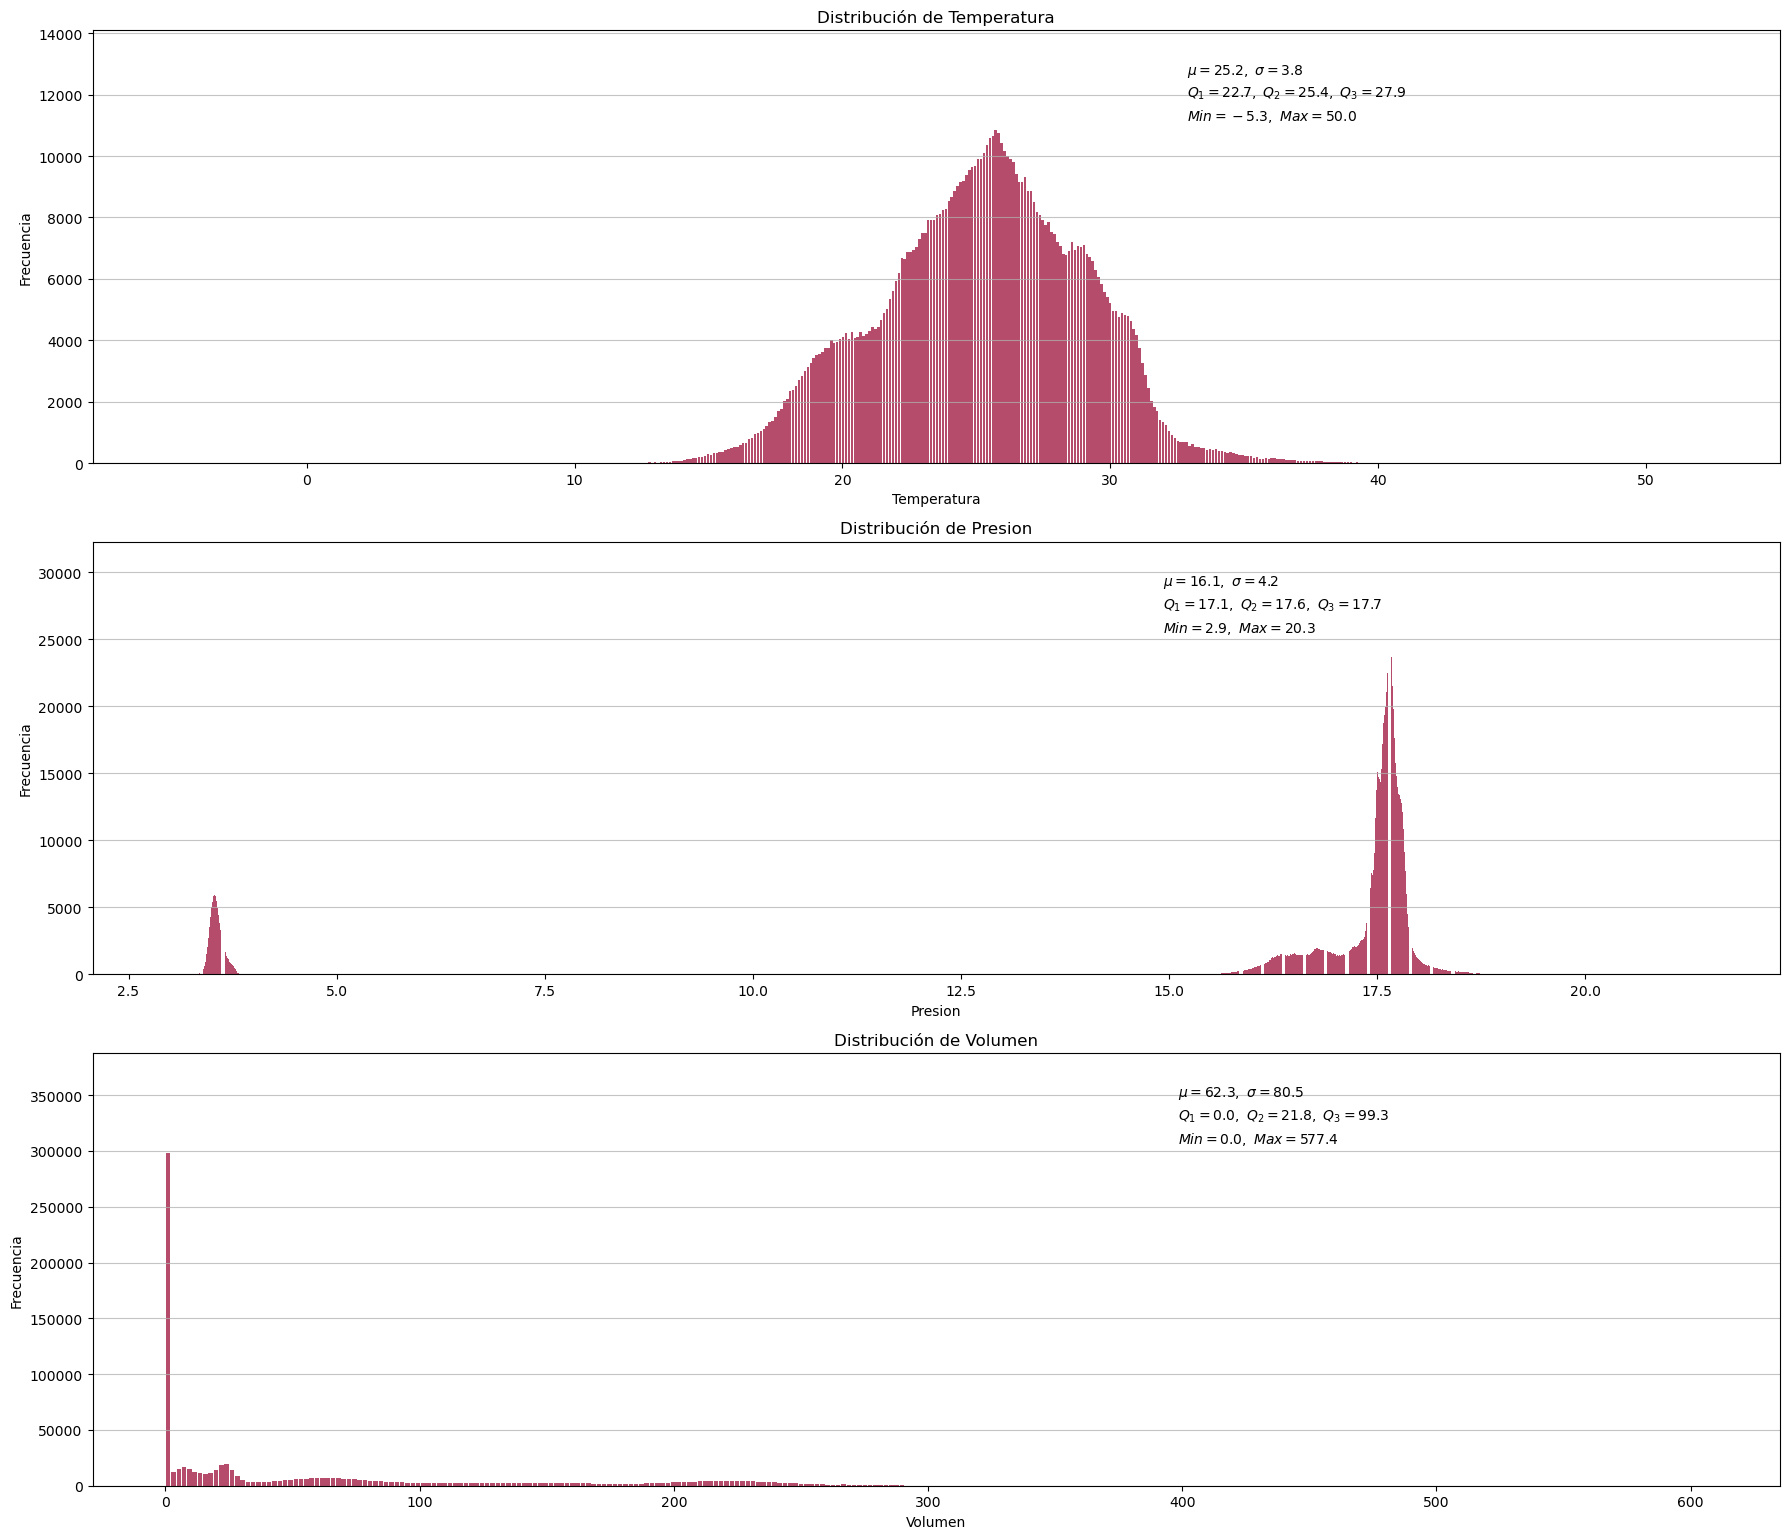

In [18]:
import matplotlib.pyplot as plt

def descriptive(datos):
    plt.figure(figsize=(18, 15.5))  # Ajuste del tamaño de la figura
    selected_vars = ['Temperatura', 'Presion', 'Volumen']  # Variables específicas
    
    for i, var in enumerate(selected_vars):
        plt.subplot(3, 1, i + 1)  # Solo 3 gráficas en filas separadas
        if len(datos[var].unique()) > 3:
            dataHist = datos[var]
            n, bins, patches = plt.hist(x=dataHist, bins='auto', color='#98002E', alpha=0.7, rwidth=0.85)
            maxfreq = n.max()
            maxval = dataHist.min() + (dataHist.max() - dataHist.min()) * 0.69
            plt.grid(axis='y', alpha=0.75)
            plt.xlabel(f'{var}')
            plt.ylabel('Frecuencia')
            plt.title(f'Distribución de {var}')
            plt.text(maxval, maxfreq * 1.17, f'$\mu={round(dataHist.mean(), 1)},$ $\sigma={round(dataHist.std(), 1)}$')
            plt.text(maxval, maxfreq * 1.1, f'$Q_1={round(dataHist.quantile(q=0.25), 1)},$ $Q_2={round(dataHist.quantile(q=0.5), 1)},$ $Q_3={round(dataHist.quantile(q=0.75), 1)}$')
            plt.text(maxval, maxfreq * 1.03, f'$Min={round(dataHist.min(), 1)},$ $Max={round(dataHist.max(), 1)}$')
            plt.ylim(ymax=maxfreq * 1.3)
            plt.xlim(xmax=dataHist.max() * 1.1)
        else:
            data = datos.groupby(var).size()
            labels = data.keys()
            colors = ['#E31B23', '#532E63']
            plt.pie(x=data, autopct="%.1f%%", labels=labels, pctdistance=0.6, startangle=120, textprops={'fontsize':12}, colors=colors)
            plt.title((f"Proporciones de {var}").format(var), fontsize=18)
        
        plt.tight_layout()  # Ajusta la posición de las gráficas
    
    plt.show()
descriptive(datos)

Las gráficas muestran la distribución de tres variables: temperatura, presión y volumen. Cada una de ellas nos proporciona información valiosa sobre cómo se distribuyen los datos de estas variables en el conjunto de datos.

Distribución de la Temperatura: La combinación de estos valores sugiere una distribución aproximadamente normal (en forma de campana), con una ligera asimetría hacia la derecha debido a la presencia de algunos valores máximos más altos. La mayoría de las temperaturas se encuentran entre 22.7 y 27.9 (el rango intercuartílico), con una concentración mayor alrededor de la media de 25.2. La presencia de un mínimo de -5.3 podría indicar un valor atípico, especialmente si las demás temperaturas están concentradas en un rango más estrecho. La desviación estándar de 3.8 indica una variabilidad moderada en los datos. Esto significa que las temperaturas pueden fluctuar considerablemente alrededor del valor promedio.

Distribución de la presión: Parece estar ligeramente sesgada hacia la izquierda. Esto se debe a que la media (16.1) es ligeramente menor que la mediana (17.6). Además, el rango intercuartílico (Q3 - Q1 = 0.6) es bastante pequeño comparado con la distancia entre el mínimo y el primer cuartil (17.1 - 2.9 = 14.2). Esto sugiere que hay más valores extremos hacia el lado inferior de la distribución. La mayoría de los datos se encuentran concentrados entre 17.1 y 17.7 (el rango intercuartílico), lo que indica una distribución relativamente estrecha. El valor mínimo de 2.9 podría considerarse un valor atípico, ya que está bastante lejos del resto de los datos. La desviación estándar de 4.2 indica una variabilidad moderada en los datos. Esto significa que las presiones pueden fluctuar considerablemente alrededor del valor promedio.

Distribución de volumen: Está fuertemente sesgada hacia la derecha. Esto se evidencia por el hecho de que la media es mayor que la mediana y que el rango entre el primer cuartil y el mínimo es mucho más pequeño que el rango entre el tercer cuartil y el máximo. Esta distribución sugiere la presencia de algunos valores muy grandes que "estiran" la cola de la distribución hacia la derecha. La presencia de muchos valores cercanos a cero y el valor máximo de 577.4 sugieren la posibilidad de valores atípicos. La alta desviación estándar indica una gran variabilidad en los datos. Esto significa que los volúmenes pueden variar considerablemente de un caso a otro.

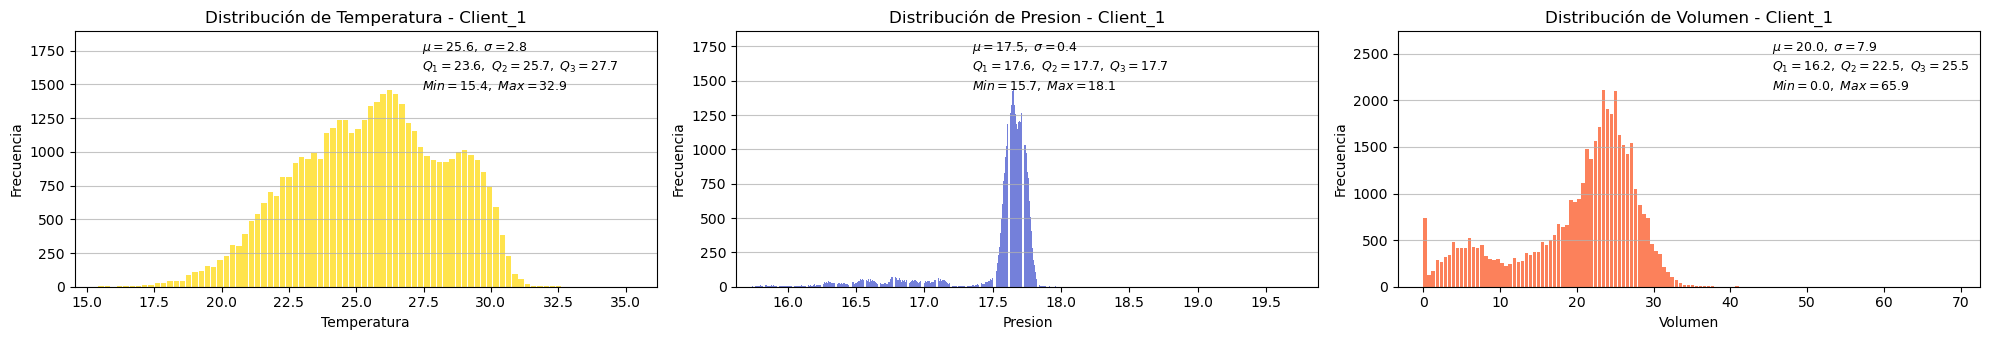

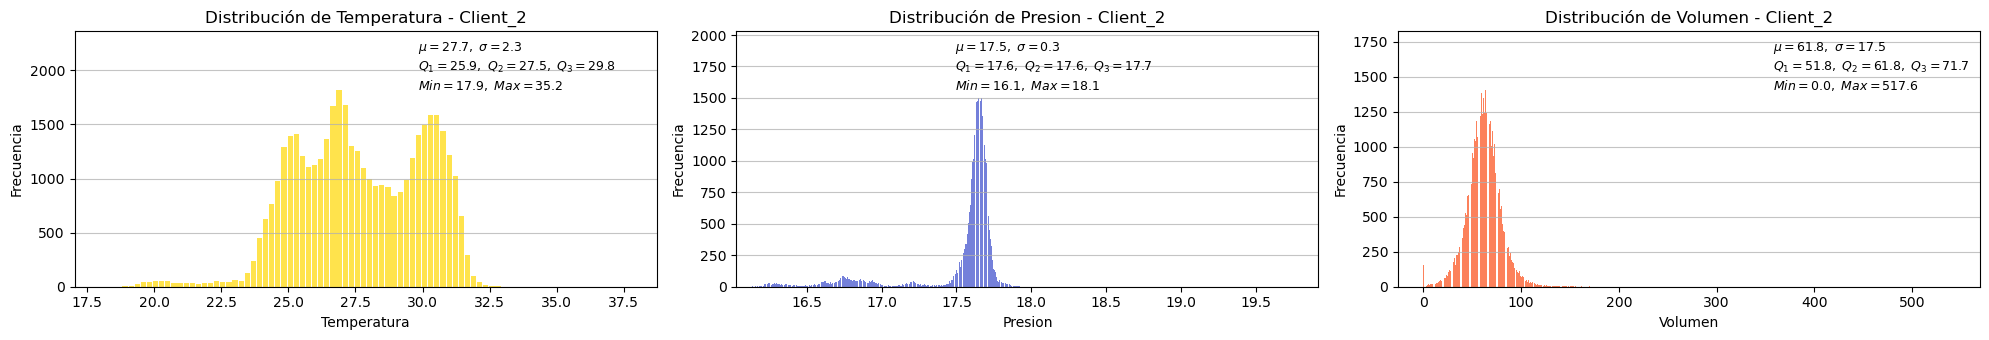

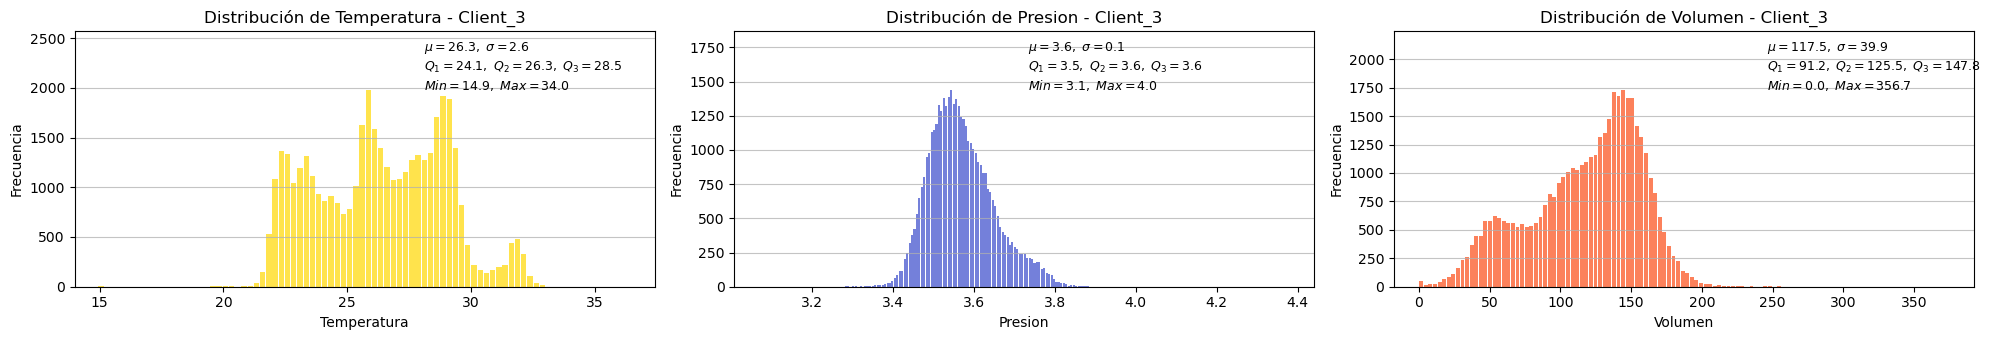

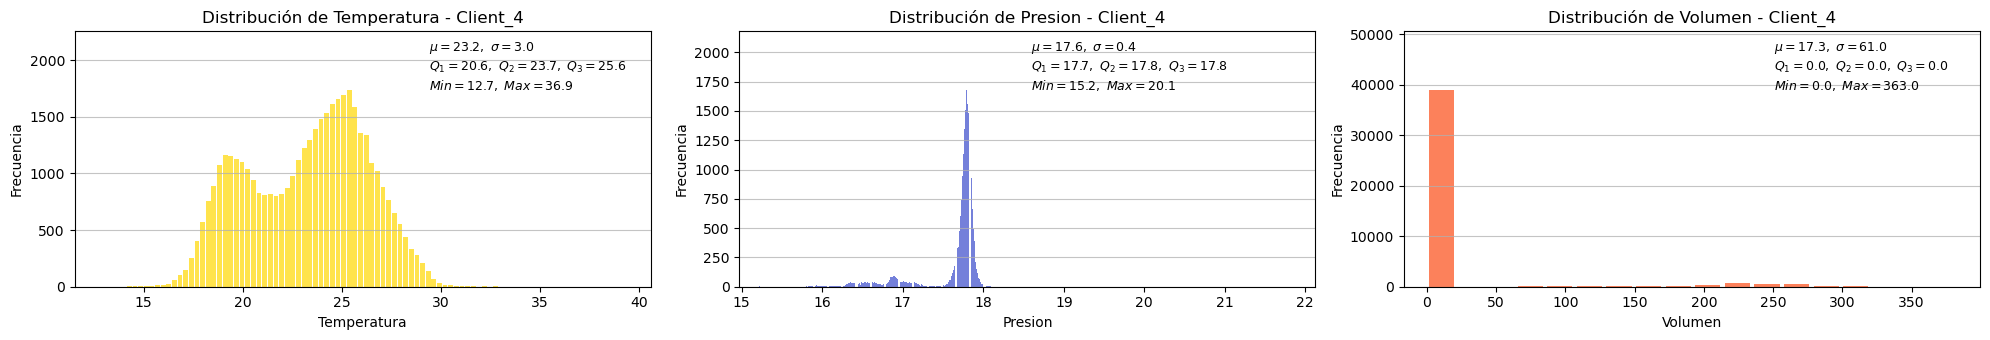

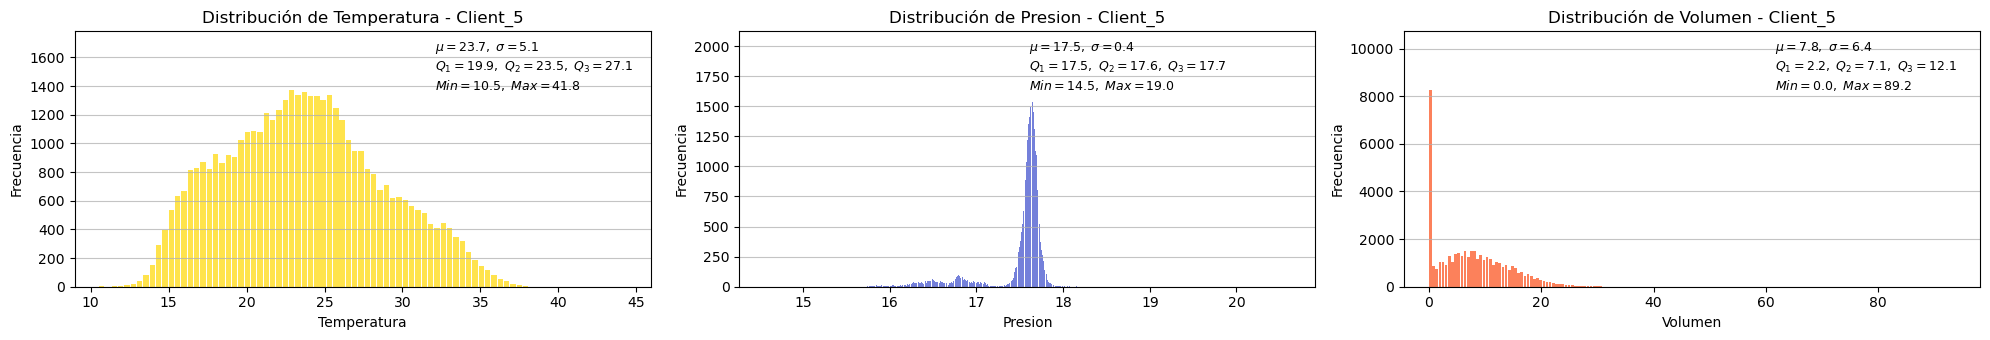

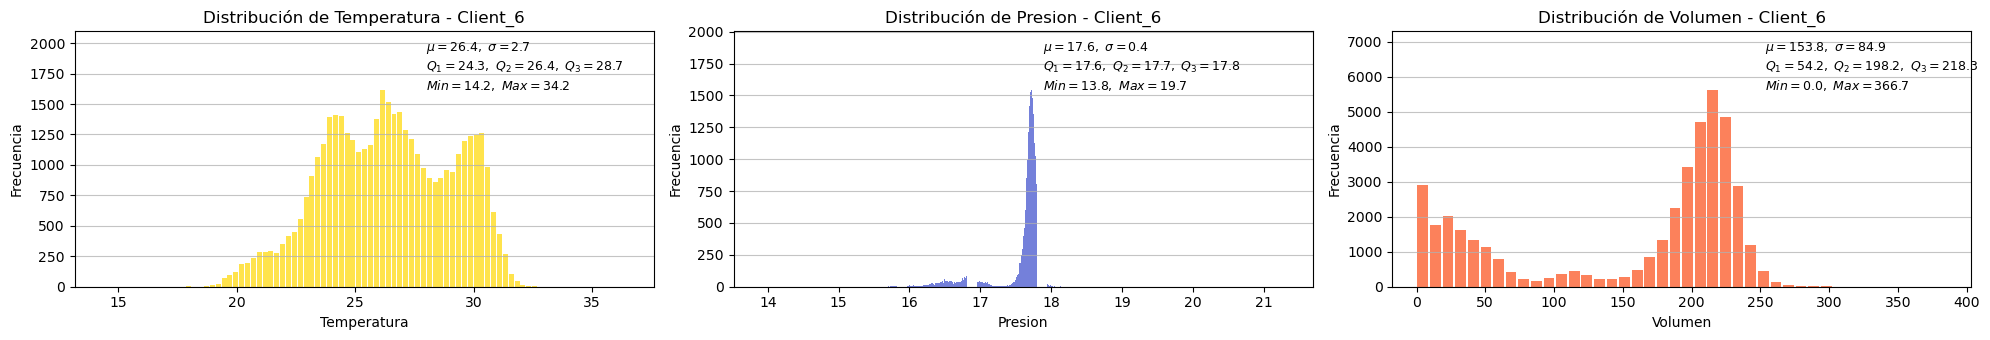

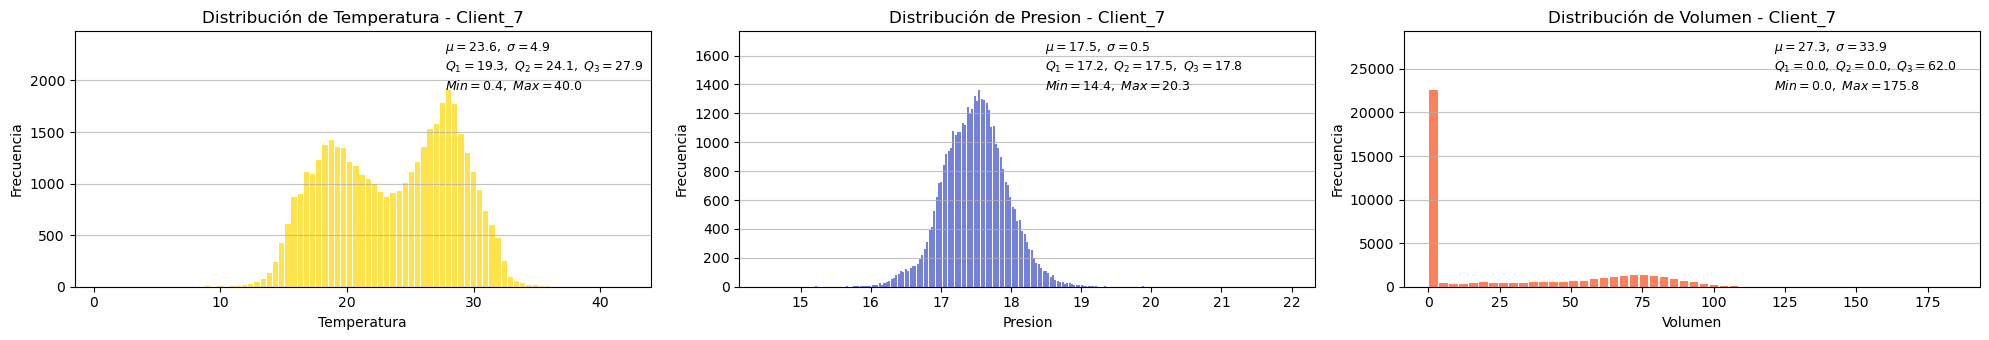

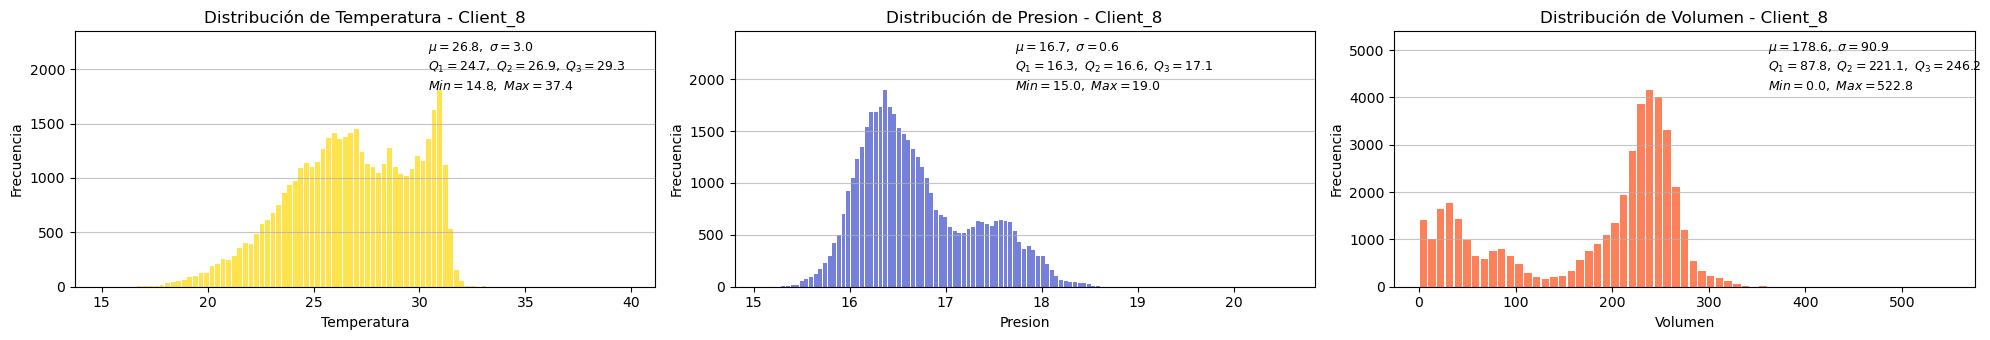

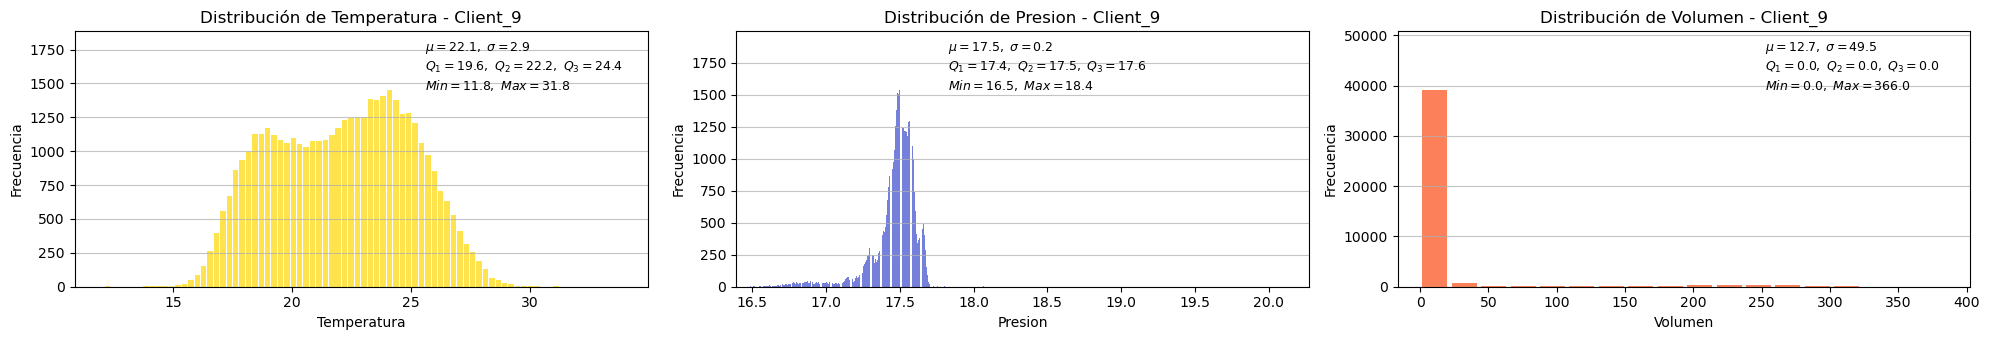

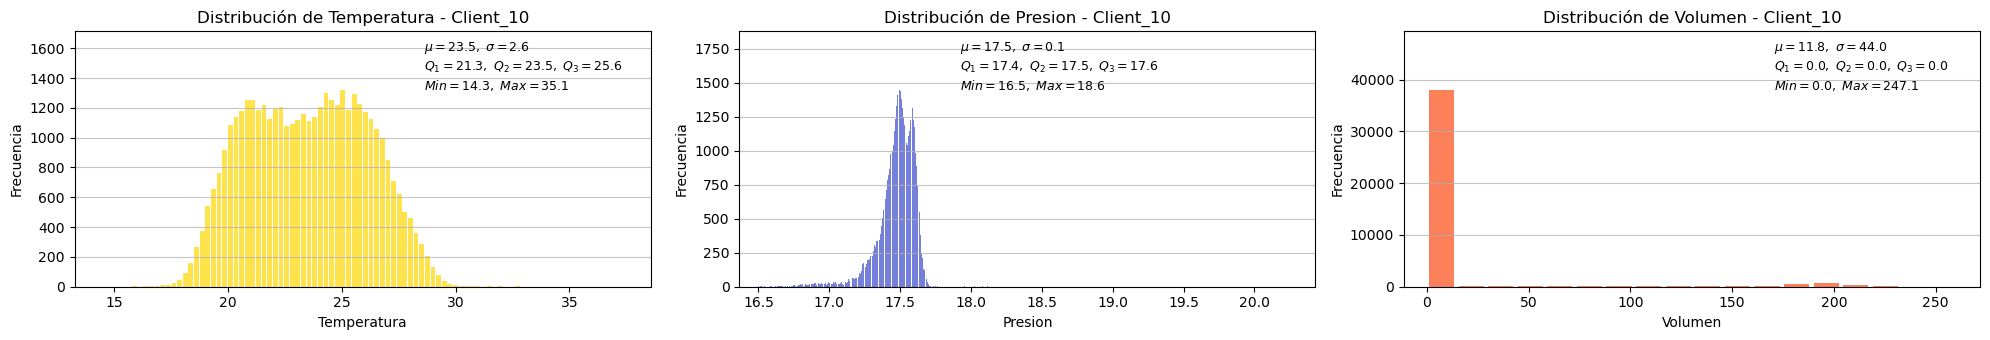

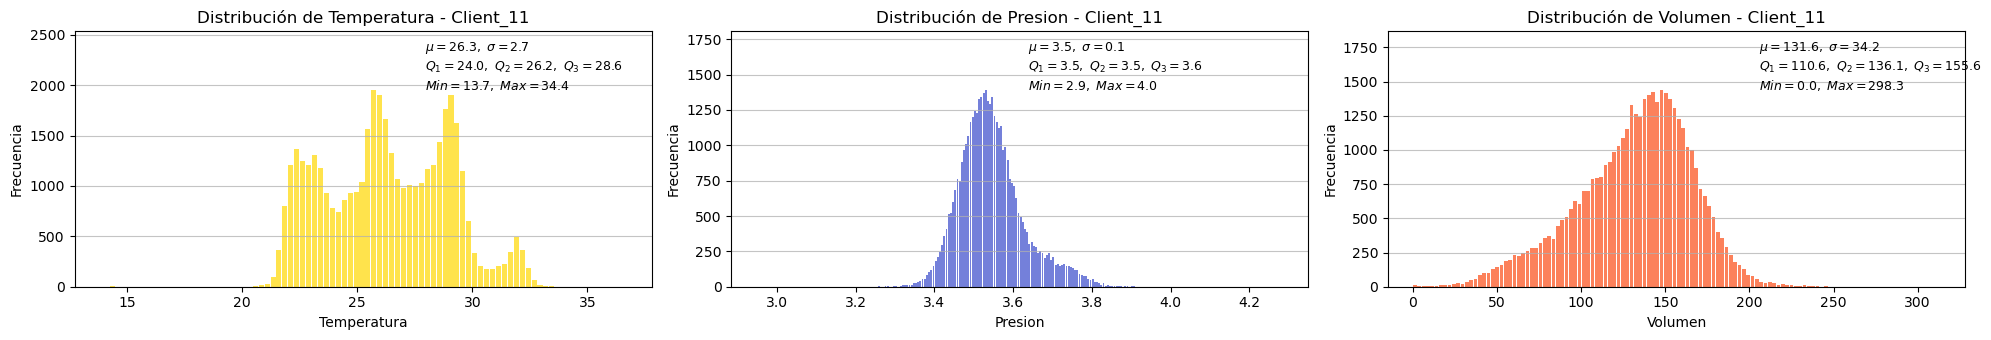

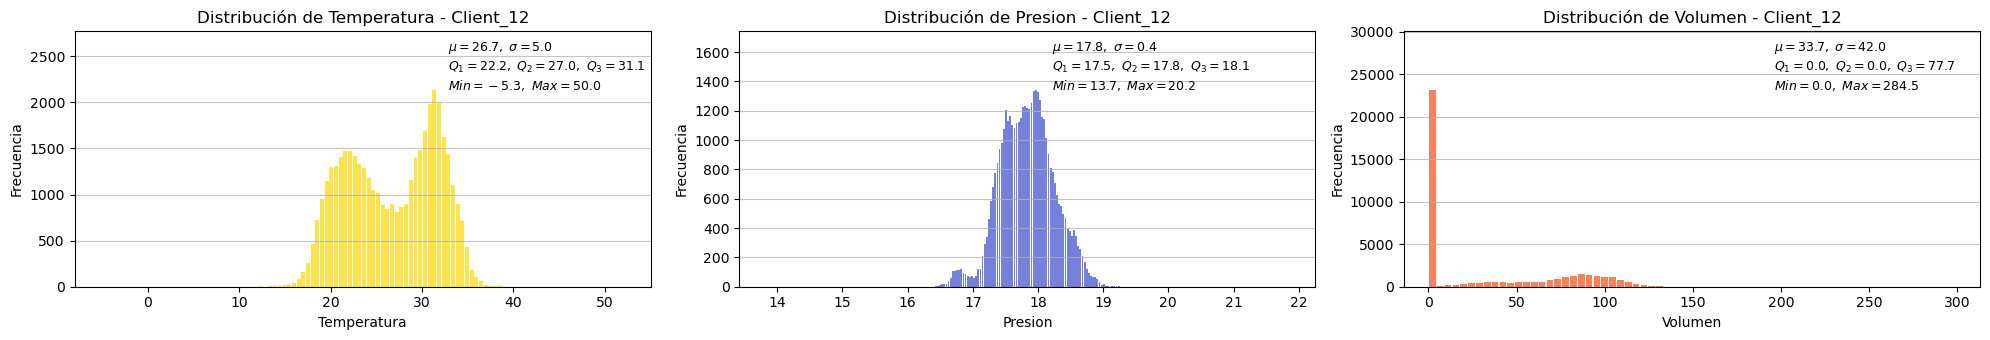

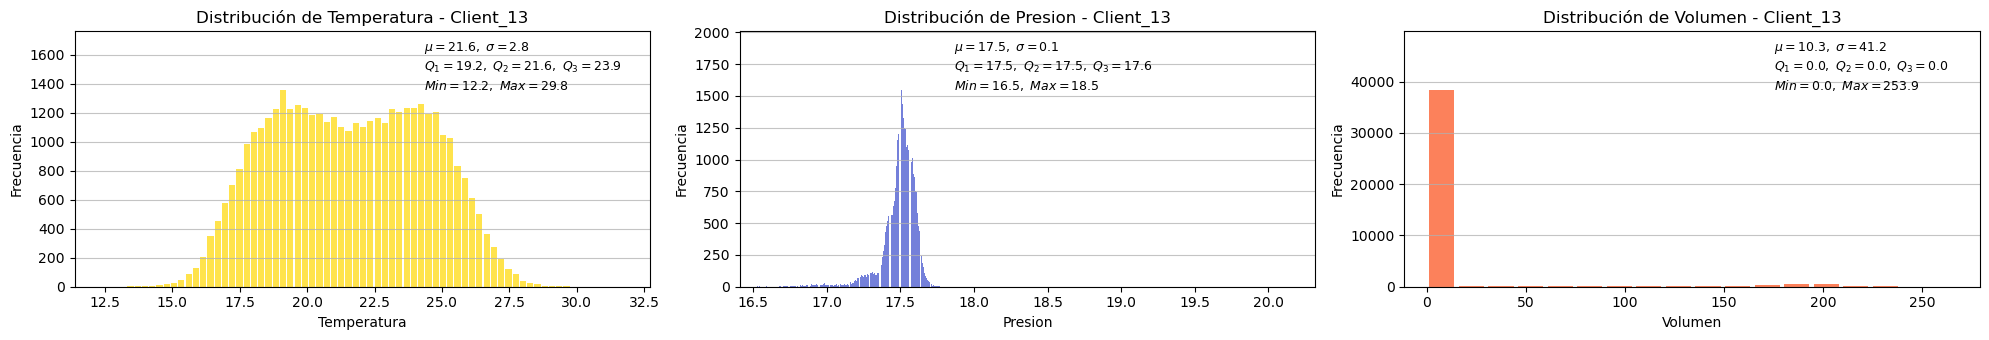

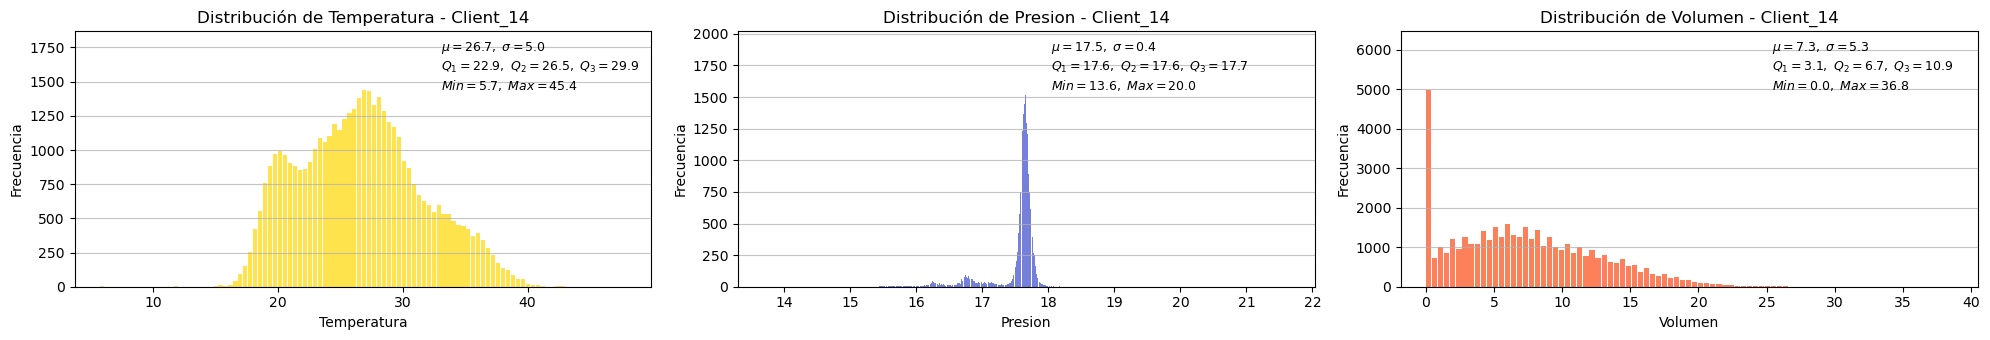

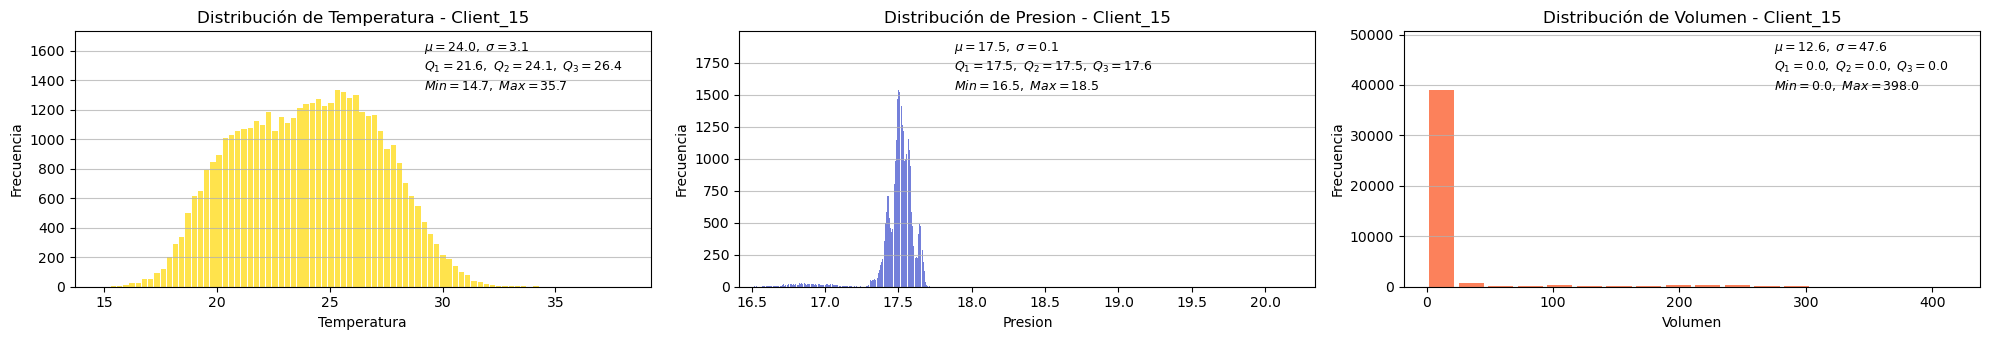

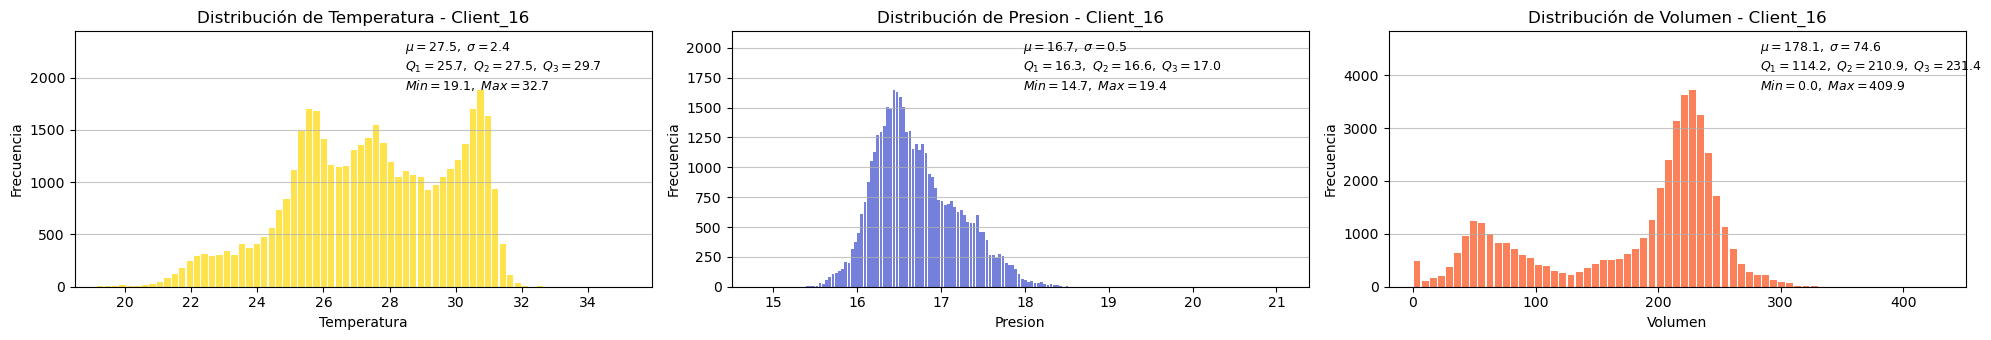

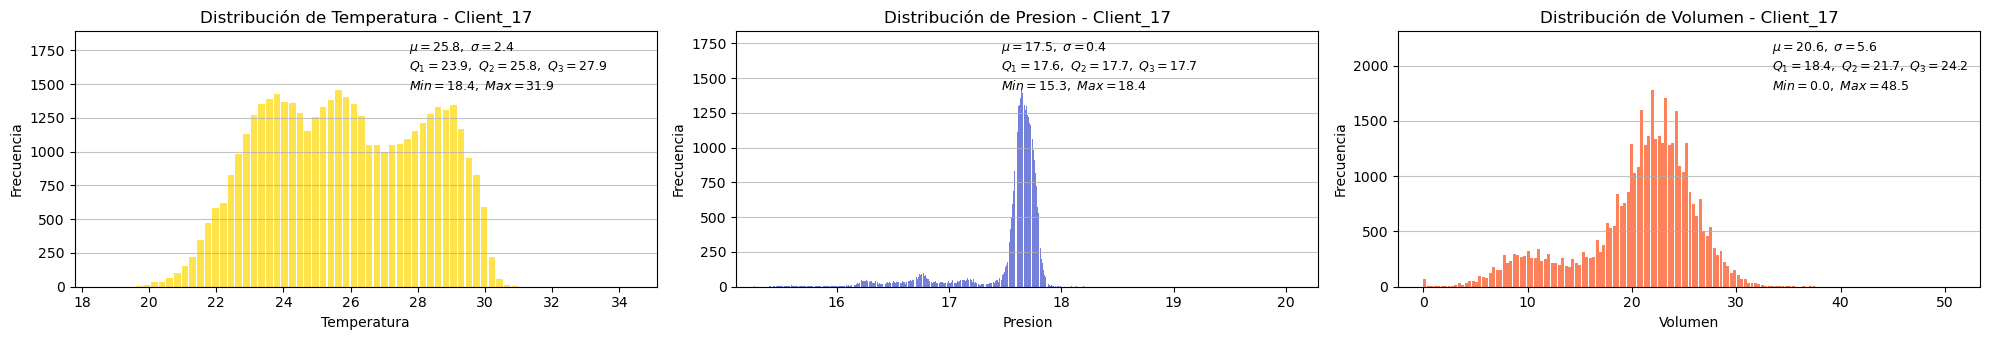

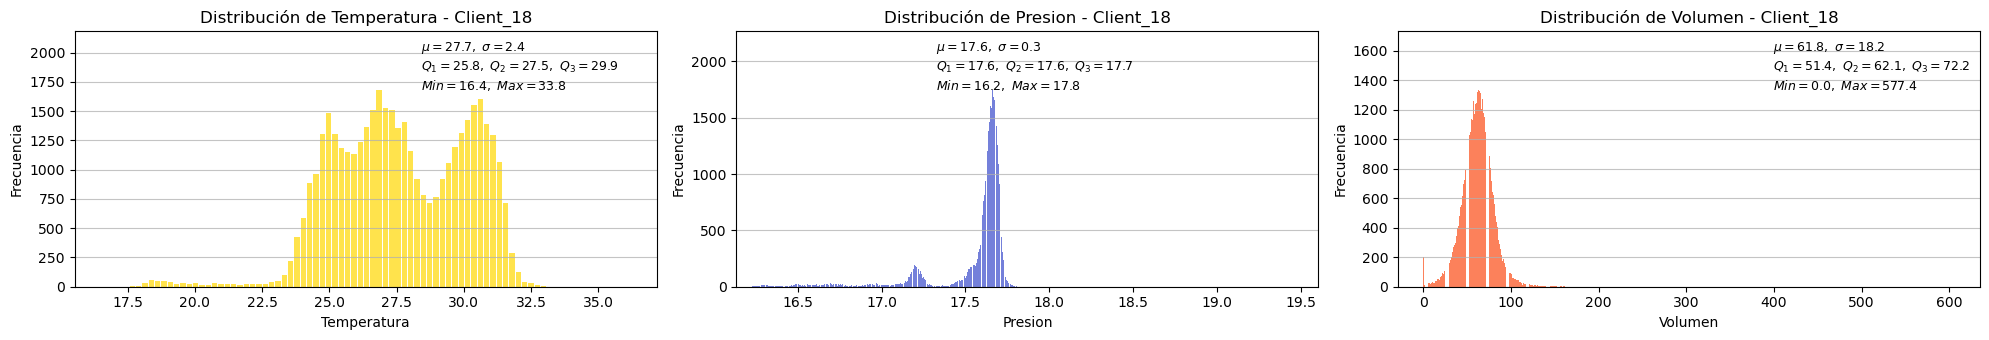

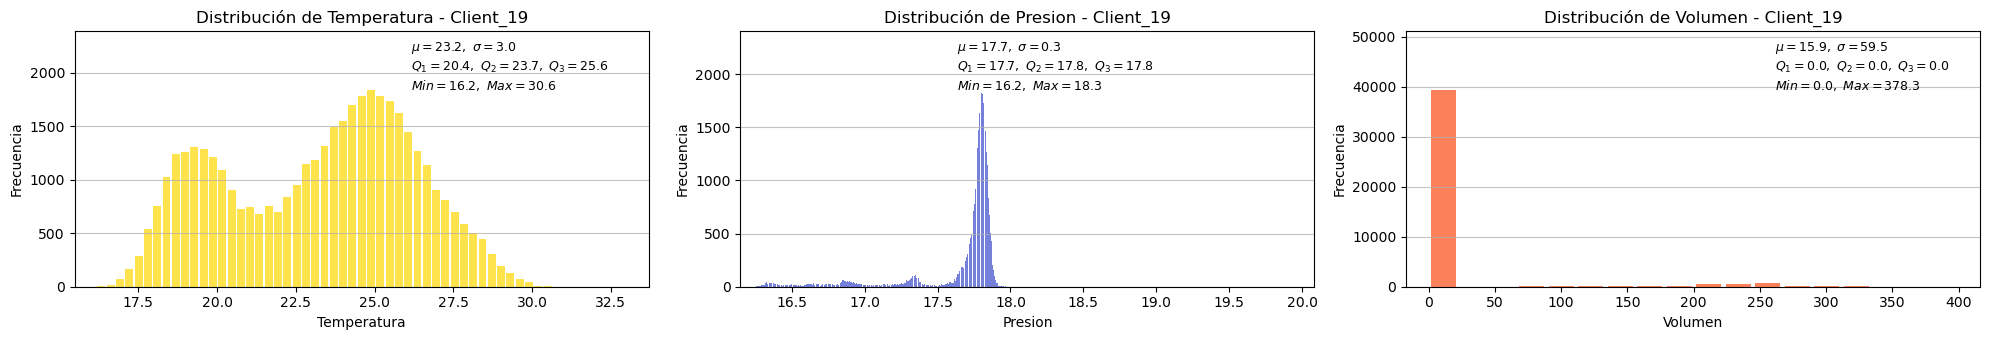

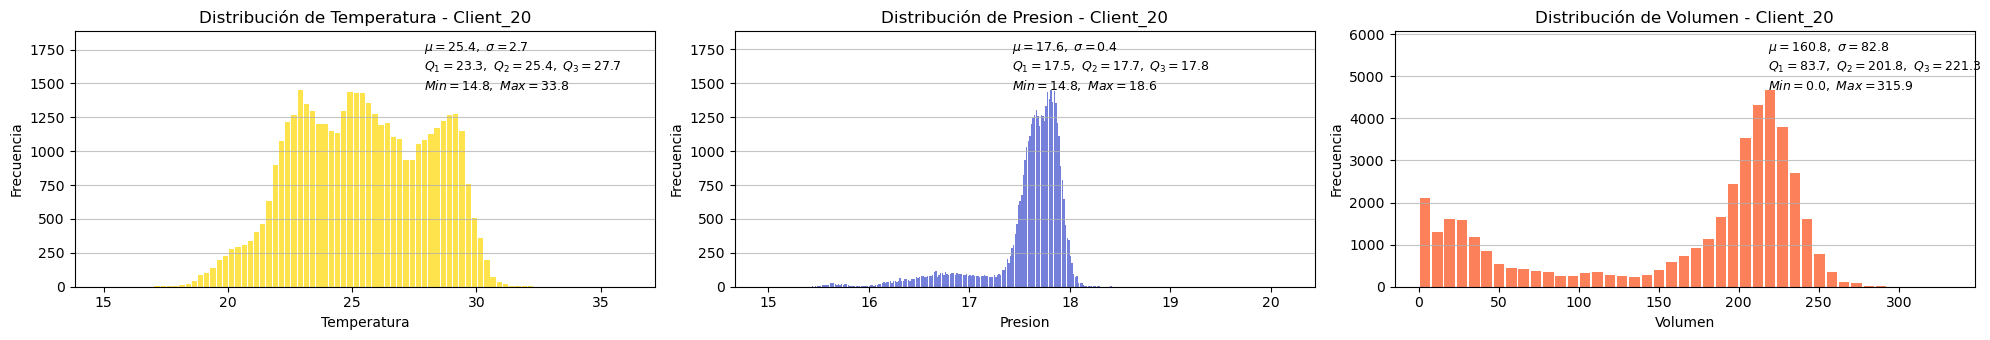

In [19]:
def descriptive_per_client(datos):
    clients = datos['Client_ID'].unique()  # Obtener IDs únicos de los clientes
    
    for client in clients:
        client_data = datos[datos['Client_ID'] == client]  # Filtrar datos por cliente
        client_data.loc[:,'Volumen'] = round(client_data['Volumen'],1)
        plt.figure(figsize=(20, 3.5))  # Ajuste del tamaño de la figura
        selected_vars = ['Temperatura', 'Presion', 'Volumen']  # Variables específicas

        for i, var in enumerate(selected_vars):
            plt.subplot(1, 3, i + 1)  # Gráficas en filas separadas
            colors = ['#ffd800', '#394acb', '#fb4c16']
            if len(client_data[var].unique()) > 3:
                dataHist = client_data[var]
                n, bins, patches = plt.hist(x=dataHist, bins='auto', color=colors[i], alpha=0.7, rwidth=0.85)
                maxfreq = n.max()
                maxval = dataHist.min() + (dataHist.max() - dataHist.min()) * 0.69
                plt.grid(axis='y', alpha=0.75)
                plt.xlabel(f'{var}')
                plt.ylabel('Frecuencia')
                plt.title(f'Distribución de {var} - {client}')
                plt.text(maxval, maxfreq * 1.2, f'$\mu={round(dataHist.mean(), 1)},$ $\sigma={round(dataHist.std(), 1)}$',fontsize=9)
                plt.text(maxval, maxfreq * 1.1, f'$Q_1={round(dataHist.quantile(q=0.25), 1)},$ $Q_2={round(dataHist.quantile(q=0.5), 1)},$ $Q_3={round(dataHist.quantile(q=0.75), 1)}$',fontsize=9)
                plt.text(maxval, maxfreq * 1.0, f'$Min={round(dataHist.min(), 1)},$ $Max={round(dataHist.max(), 1)}$',fontsize=9)
                plt.ylim(ymax=maxfreq * 1.3)
                plt.xlim(xmax=dataHist.max() * 1.1)
            else:
                data = client_data.groupby(var).size()
                labels = data.keys()
                colors = ['#E31B23', '#532E63']
                plt.pie(x=data, autopct="%.1f%%", labels=labels, pctdistance=0.6, startangle=120, textprops={'fontsize':12}, colors=colors)
                plt.title((f"Proporciones de {var} - {client}").format(var), fontsize=18)
            
            plt.tight_layout()  # Ajusta la posición de las gráficas

        plt.show()

descriptive_per_client(datos)

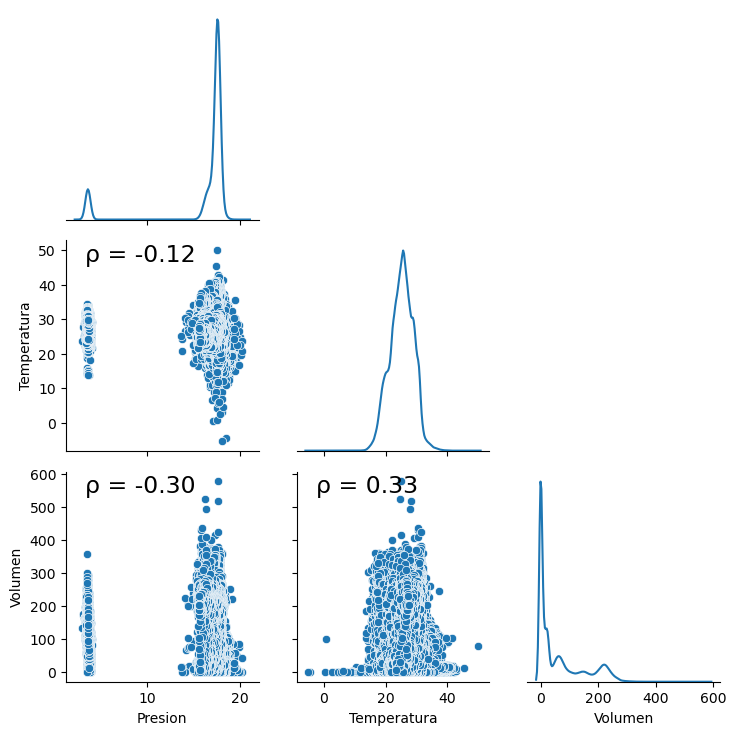

In [20]:
cats = ['Client_ID', 'Fecha']
cont = list(set(datos.columns) - set(cats))
## Correlogramas
def corrfunc(x, y, ax=None, **kws):
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, fontsize= 17)
g = sns.PairGrid(datos[cont], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.map_lower(corrfunc)

Esta gráfica nos proporciona una visión general de las relaciones entre tres variables: temperatura, presión y volumen. Los diagramas de dispersión y los histogramas nos permiten visualizar estas relaciones de manera clara y concisa.

Diagramas de Dispersión:

Temperatura vs. Volumen (ρ = 0.33): Este diagrama muestra una correlación positiva moderada entre la temperatura y el volumen. Esto significa que, a medida que aumenta la temperatura, también tiende a aumentar el volumen. Esta relación es consistente con la Ley de Charles, que establece que a presión constante, el volumen de un gas es directamente proporcional a su temperatura absoluta.   
Presión vs. Volumen (ρ = -0.30): Este diagrama muestra una correlación negativa moderada entre la presión y el volumen. Esto significa que, a medida que aumenta la presión, el volumen tiende a disminuir. Esta relación es consistente con la Ley de Boyle, que establece que a temperatura constante, el producto de la presión y el volumen de un gas es constante.   
Temperatura vs. Presión (ρ = -0.12): Este diagrama muestra una correlación negativa débil entre la temperatura y la presión. Aunque la relación no es tan fuerte como en los otros casos, sugiere que a medida que aumenta la temperatura, la presión tiende a disminuir ligeramente.

Histogramas:

Los histogramas muestran la distribución de cada variable individualmente. En este caso, las distribuciones de temperatura y presión parecen ser aproximadamente normales, lo que indica que la mayoría de los valores se concentran alrededor de un valor central. La distribución del volumen parece estar ligeramente sesgada hacia la derecha, lo que sugiere que hay algunos valores de volumen muy altos que afectan la forma de la distribución.

La correlación entre temperatura, presión y volumen observadas en la gráfica son consistentes con las leyes de los gases ideales. La correlación positiva entre temperatura y volumen, y la correlación negativa entre presión y volumen son las más fuertes. La distribución del volumen es ligeramente sesgada, lo que podría indicar la presencia de valores atípicos o una heterogeneidad en los datos.

## Tratamiento de los datos

Entendiendo que el unico problema presente en los datos es la falta de secuencia temporal de los cleintes Client_8 y Client_16 se requiere seleccionar un método de imputación. La interpolación lineal es el método más adecuado para imputar los datos faltantes en este caso debido a la naturaleza continua y estable de las variables (presión, temperatura y volumen) en sistemas industriales de gas. Este método es eficiente computacionalmente, fácil de implementar y no requiere ajustes complejos, lo que lo hace ideal para brechas temporales cortas. Además, garantiza consistencia al generar valores que siguen las tendencias observadas antes y después de las brechas, asegurando una imputación coherente con los patrones originales del sistema.

In [21]:
def find_missing_dates(datos, client_id, freq='h'):
    client_data = datos[datos['Client_ID'] == client_id].sort_values('Fecha')
    expected_dates = pd.date_range(start=client_data['Fecha'].min(), 
                                   end=client_data['Fecha'].max(), freq=freq)
    actual_dates = client_data['Fecha']
    missing_dates = expected_dates.difference(actual_dates)
    return missing_dates

In [22]:
# Diccionario para almacenar las fechas faltantes por cliente
missing_dates_dict = {}

# Identificar y guardar fechas faltantes para cada cliente con problemas
for client_id in ['Client_16', 'Client_8']:
    missing_dates_dict[client_id] = find_missing_dates(datos, client_id)

In [23]:
def add_missing_dates(datos, client_id, missing_dates):
    # Crear un DataFrame con las fechas faltantes
    missing_data = pd.DataFrame({'Fecha': missing_dates, 'Client_ID': client_id})
    
    # Unir con el DataFrame original y ordenar por cliente y fecha
    datos = pd.concat([datos, missing_data], ignore_index=True).sort_values(by=['Client_ID', 'Fecha'])
    return datos

# Agregar fechas faltantes para cada cliente
for client_id, missing_dates in missing_dates_dict.items():
    datos = add_missing_dates(datos, client_id, missing_dates)

In [24]:
# Imputación general de valores
datos['Presion'] = datos['Presion'].interpolate(method='linear')
datos['Temperatura'] = datos['Temperatura'].interpolate(method='linear')
datos['Volumen'] = datos['Volumen'].interpolate(method='linear')

In [25]:
validate_completeness(datos)

Número de registros sin Client_ID: 0

Clientes con fechas no secuenciales o faltantes:
Series([], Name: Fecha, dtype: bool)


In [26]:
print("La dimensión de los datos es: " + str(datos.shape))

La dimensión de los datos es: (848692, 5)


Después de incorporar las fechas faltantes para Client_16 y Client_8, el tamaño del conjunto de datos aumentó a 848,692 registros, lo que indica que las brechas identificadas fueron correctamente añadidas a los datos. Posteriormente, se aplicó la imputación lineal a las variables Presión, Temperatura y Volumen, completando los valores faltantes de manera coherente con las tendencias existentes. La validación de completitud confirmó que no hay registros con fechas faltantes ni desordenadas, lo que asegura la continuidad temporal en los datos. Este resultado demuestra que el proceso fue exitoso, mejorando la calidad e integridad del dataset para futuros análisis.

## Preprocesamiento

In [ ]:
#XTrain, XTest, yTrain, yTest = train_test_split(XTotal, YTotal, test_size=0.33, random_state=0)

In [ ]:
# scaler = StandardScaler(with_mean=True, with_std=True)
# scaler.fit(XTrain)
# XEscaladoTrain=scaler.transform(XTrain)
# XEscaladoTest=scaler.transform(XTest)

## Conclusiones